# Introducción a python: Ajuste de Parámetros en un Modelo (Minimización)





Para este ejemplo utilizaremos la ecuación del modelo-$\beta$ proyectado en la linea de visión: $$\rho(\theta;\vec{\Omega})=\rho_0\left(\frac{\theta^2}{\theta_c^2}+1\right)^{(1-3\beta)/2}, $$ donde $\theta$ es el la distancia angular con respecto del centro del perfil, $\rho_0$ es la densidad central, $\theta_c$ es el tamaño angular del nucle, $\beta$ es la pendiente exponencial a escalas $\theta>\theta_c$. Este modelo se utiliza para caracterizar la atmósfera de los cúmulos de galaxias (el medio intracúmulo o ICM por sus siglas en inglés). 

En este caso, el vector $\vec{\Omega}$ se le conoce como **vector de parámetros** y para este modelo: $$\vec{\Omega} = (\rho_c,\theta_c,\beta). $$

Definimos una función en *python* para describir este modelo:

In [2]:
def beta_model (theta, rho_0, theta_c, beta ):
  return rho_0*((theta/theta_c)**2 +1)**((1-3*beta)/2)

Asignemos algunos valores al vector de parámetros y evaluemos el modelo:

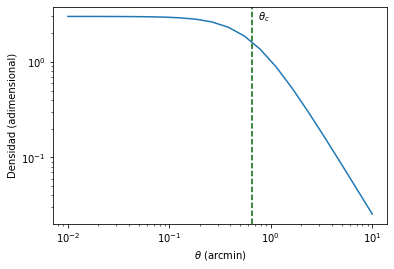

In [3]:
import numpy as np
from matplotlib import pyplot as plt

theta_c = np.random.uniform (0.5,2)   #arcmin
beta = np.random.uniform (0.6,1)
rho_0 = np.random.uniform (1,10)       #

theta = np.geomspace (0.01, 10,20)

underlying_model = beta_model(theta, rho_0, theta_c, beta)
plt.plot(theta, underlying_model)
plt.xscale("log")
plt.yscale("log")
plt.xlabel (r"$\theta$ (arcmin)")
plt.ylabel ("Densidad (adimensional)")
plt.axvline(theta_c, color ="DarkGreen", ls = "--")
plt.text (theta_c, rho_0, r"  $\theta_c$", ha="left", va="center")
pass

Por lo general, nuestras las observaciones contienen un señales adicionales que no pertenecen al modelo. Este **ruido** dificulta la obtención de los valores ***reales*** de los parámetros. Por este motivo, se dice que estamos **estimando** el valor de los parámetros. 

Agregemos un poco de ruido a nuestro modelo y creemos una observación sintética:

Text(0, 0.5, 'Densidad (adimensional)')

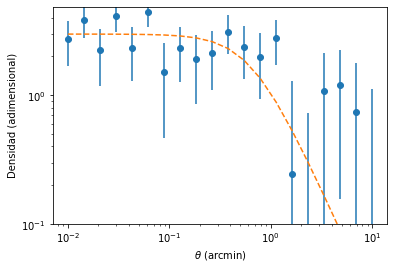

In [18]:
observation_noise = 0.35*underlying_model.max()
observed_model = underlying_model +np.random.normal(scale = observation_noise, size=theta.shape)

plt.errorbar(theta, observed_model, observation_noise, marker = 'o', ls = "")
plt.plot(theta, underlying_model, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.ylim (1e-1,1.1*observed_model.max())
plt.xlabel (r"$\theta$ (arcmin)")
plt.ylabel ("Densidad (adimensional)")

El proceso de ajuste consiste en estimar un vector de parámetros $\hat{\Omega}$ que minimize una función que mide la similitud de los datos con el modelo. Esta función se conoce como **función de mérito** (FOM por sus siglas en inglés). La función **chi cuadrada** se utiliza ampliamente para este propósito: $$\chi^2= \sum^N_i \frac{(y_i - \rho(\theta_i,\vec{\Omega}))^2}{\sigma_i^2},$$ donde $y_i$ representa los datos observados, $\sigma_i$ el error asociado con cada punto observado y $N$ es el número de puntos observados.

Definimos nuestra función de mérito:

In [10]:
def chi_beta_model (parameters, x,y, noise):
  
  chi = (y - beta_model(x,*parameters))/noise
  chi2 = chi**2

  return chi2.sum()

Ahora minimizamos la FOM empleando la función minimize incluida en scipy. Es importante notar que en la mayoría de los métodos de minimización debemos de especificar un punto d e partida para buscar el mínimo (*initial gueess*):

In [14]:
from scipy.optimize import minimize

Omega_init = (0.25,0,0.5) 

fit_results =  minimize(chi_beta_model, Omega_init, \
                        args =(theta,\
                               observed_model,\
                                observation_noise))
if fit_results.success:
    print ("El ajuste fue exitoso.")
    for ipar, ilabel in zip(fit_results.x, ["P0", "theta_c", "beta"]):
        print ("Valor del parámetro {}: {}".format(ilabel,ipar))
else:
    print ("Algo fallo con el ajuste")

El ajuste fue exitoso.
Valor del parámetro P0: 2.936905218272141
Valor del parámetro theta_c: 0.5491573435059656
Valor del parámetro beta: 0.8396190215956583


<ipython-input-2-c147a41aa2cb>:2: RuntimeWarning: divide by zero encountered in true_divide
  return rho_0*((theta/theta_c)**2 +1)**((1-3*beta)/2)


Ahora veamos la gráfica del modelo:

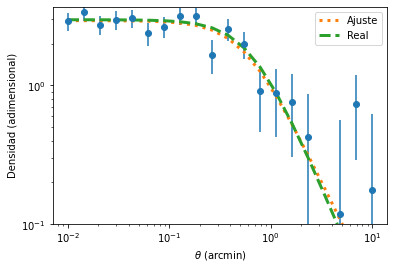

In [15]:
fit_model = beta_model(theta, *fit_results.x)

plt.errorbar(theta, observed_model, observation_noise, marker = 'o', ls = "")
plt.plot(theta, fit_model, ls=":", lw =3, label = "Ajuste")
plt.plot(theta, underlying_model, ls = "--", lw = 3, label = "Real")
plt.xscale("log")
plt.yscale("log")
plt.ylim (1e-1,1.1*observed_model.max())
plt.xlabel (r"$\theta$ (arcmin)")
plt.ylabel ("Densidad (adimensional)")
plt.legend()

Otra función que podemos emplear de la librería scipy es **curve_fit**, la cual permite calcular el error en los parámetros

Valor del parámetro P0: 2.86 +/- 0.301
Valor del parámetro theta_c: 0.69 +/- 0.763
Valor del parámetro beta: 0.63 +/- 0.278


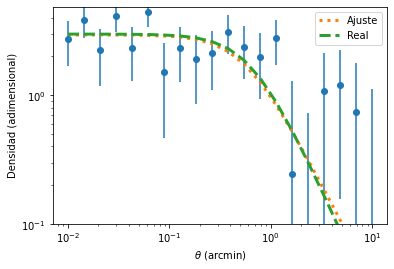

In [19]:
from scipy.optimize import curve_fit

parameter, uncertainties = curve_fit (beta_model,theta,\
                                      observed_model, \
                                      sigma = observation_noise*\
                                            np.ones(theta.shape))

for ipar, ilabel, ierror in zip(parameter, ["P0", "theta_c", "beta"],  np.diag(uncertainties)):
        print ("Valor del parámetro {}: {:.2f} +/- {:.3}".format(ilabel,ipar, ierror**0.5))

fit_model2 = beta_model(theta,*parameter)
plt.errorbar(theta, observed_model, observation_noise, marker = 'o', ls = "")
plt.plot(theta, fit_model, ls=":", lw =3, label = "Ajuste")
plt.plot(theta, underlying_model, ls = "--", lw = 3, label = "Real")
plt.xscale("log")
plt.yscale("log")
plt.ylim (1e-1,1.1*observed_model.max())
plt.xlabel (r"$\theta$ (arcmin)")
plt.ylabel ("Densidad (adimensional)")
plt.legend()


### Ajuste en dos dimensiones

Podemos trabajar con un ajuste n-dimensional. Para el caso del ejemplo anterior:

Text(0.5, 1.0, 'Observado')

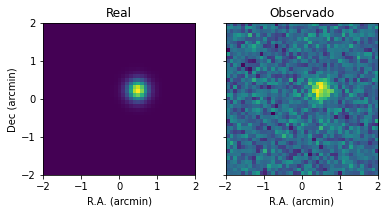

In [22]:
theta_c = np.random.uniform (0.5,2)   #arcmin
beta = np.random.uniform (0.6,1)
rho_0 = np.random.uniform (1,10)       #
#Permitimos que el centro del cúmulo sea aleatorio
x0 = np.random.uniform(-1,1)
y0 = np.random.uniform(-1,1)

x = np.arange(-2,2.1,0.1)
y = x.copy()

matx,maty = np.meshgrid(x,y)

r = np.sqrt((matx-x0)**2+(maty-y0)**2)


umodel_2d = beta_model (r, theta_c, beta, rho_0)
obs_noise = 0.15*umodel_2d.max()
obs_model = umodel_2d + np.random.normal(scale=obs_noise, size=umodel_2d.shape)
fig,axis = plt.subplots(1,2,sharey=True)
axis[0].imshow(umodel_2d, extent=[x[0],x[-1],y[0],y[-1]],origin="lower")
axis[1].imshow(obs_model, extent=[x[0],x[-1],y[0],y[-1]],origin="lower")
axis[0].set_xlabel("R.A. (arcmin)")
axis[1].set_xlabel("R.A. (arcmin)")
axis[0].set_ylabel("Dec (arcmin)")
axis[0].set_title ("Real")
axis[1].set_title ("Observado")

Redefinimos la función de ajuste para recibir las coordenadas y trabajar con los nuevos parámetros ($x_0,y_0$). Nótese que el truco es usar el método **flatten** de numpy.

Valor del parámetro P0: 1.83 +/- 0.129
Valor del parámetro theta_c: -31.93 +/- 1.76e+04
Valor del parámetro beta: 8177.44 +/- 8.98e+06
Valor del parámetro x0: 0.48 +/- 0.0128
Valor del parámetro y0: 0.24 +/- 0.0131


Text(0.5, 1.0, 'Real-Ajuste')

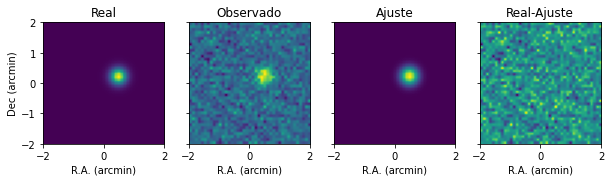

In [24]:
def beta_model_2d(coords, rho_0, theta_0, beta, x0, y0):
    
    x = coords[0]
    y = coords[1]
    
    r = np.sqrt((x-x0)**2+(y-y0)**2)
    return beta_model(r,rho_0, theta_0,beta).flatten()

p0 = [obs_model.max(), 10, 0.6,-0.5,0.5]

parameter, uncertainties = curve_fit (beta_model_2d,(matx,maty),\
                                      obs_model.flatten(),\
                                      p0 = p0,\
                                      sigma = obs_noise*\
                                            np.ones(matx.shape).flatten())

for ipar, ilabel, ierror in zip(parameter,\
                                ["P0", "theta_c", "beta", "x0", "y0"],\
                                np.diag(uncertainties)):
        print ("Valor del parámetro {}: {:.2f} +/- {:.3}".format(ilabel,ipar, ierror**0.5))
        

fit_model_2d = beta_model_2d((matx,maty),*parameter)
fit_model_2d = fit_model_2d.reshape(matx.shape)
#res = umodel_2d -fit_model_2d
res = obs_model -fit_model_2d
fig,axis = plt.subplots(1,4,sharey=True, figsize=(10,6))
axis[0].imshow(umodel_2d, extent=[x[0],x[-1],y[0],y[-1]],origin="lower")
axis[1].imshow(obs_model, extent=[x[0],x[-1],y[0],y[-1]],origin="lower")
axis[2].imshow(fit_model_2d, extent=[x[0],x[-1],y[0],y[-1]],origin="lower")
axis[3].imshow(res, extent=[x[0],x[-1],y[0],y[-1]],origin="lower")
for iax in axis:
    iax.set_xlabel("R.A. (arcmin)")

axis[0].set_ylabel("Dec (arcmin)")
axis[0].set_title ("Real")
axis[1].set_title ("Observado")
axis[2].set_title ("Ajuste")
axis[3].set_title ("Real-Ajuste")

In [ ]:
lmfit (emcee)